<a href="https://colab.research.google.com/github/milaadshaabaani/CartPole-DRL/blob/master/Deep_RL_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "value_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,642
Trainable params: 4,642
Non-trainable params: 0
_________________________________________________________________
Model: "target_model"
_________________________________________________________________
Layer (type)                 Ou

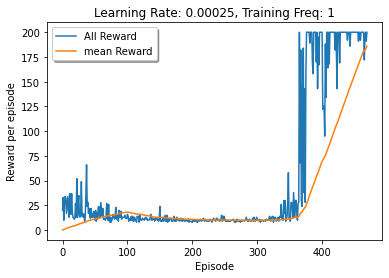

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import gym
import numpy as np
from collections import deque
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop
import random
import matplotlib.pyplot as plt

def BuildModel(input_shape, action_space,model_name,compile_flg,learning_rate):
    X_input = Input(input_shape)
    X = Dense(64, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)
    X = Dense(32, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name=model_name)
    if compile_flg:
        model.compile(loss="mse", optimizer=RMSprop(lr=learning_rate, rho=0.95, epsilon=0.01), metrics=["accuracy"])
    
    model.summary()
    return model

class DQNAgent:
    def __init__(self):
       
        self.env = gym.make('CartPole-v0')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.EPISODES = 1000
        self.memory = deque(maxlen=500000)

        self.target_update_frequency = 1000
        self.learning_start = 1000
        self.training_frequency = 1

        self.learning_rate = 0.00025
        self.disc_fac = 0.99    
        
        self.initial_epsilon = 1.0
        self.minimum_epsilon = 0.1
        self.epsilon_decay = 0.999
        
        self.batch_size = 64
        
        self.all_step = 0
        self.train_counter = 0

        self.value_model = BuildModel(input_shape=(self.state_size,), action_space = self.action_size,model_name='value_model',compile_flg=True,learning_rate=self.learning_rate)
        self.target_model = BuildModel(input_shape=(self.state_size,), action_space = self.action_size,model_name='target_model',compile_flg=False,learning_rate=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.learning_start:
            if self.initial_epsilon > self.minimum_epsilon:
                self.initial_epsilon *= self.epsilon_decay

    def act(self, state):
        if random.random() <= self.initial_epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.value_model.predict(state))

    def replay(self):
        if len(self.memory) < self.learning_start:
            return

        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

       
        target = self.value_model.predict(state)
        target_next = self.target_model.predict(next_state)

        for i in range(self.batch_size):
            
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.disc_fac * (np.amax(target_next[i]))


        self.value_model.fit(state, target, batch_size=self.batch_size, verbose=0)
        self.train_counter += 1
        if self.train_counter % self.target_update_frequency == 0:
            self.target_model.set_weights(self.value_model.get_weights())


            
    def run(self):
        all_reward=[]
        mean_reward = []
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            ep_reward =0
            i = 0
            while not done:
                # self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                ep_reward += reward
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:                   
                    print("episode: {}/{}, step: {}, e: {:.2}".format(e, self.EPISODES, i, self.initial_epsilon))
                self.all_step += 1
                if (self.all_step % self.training_frequency) == 0:
                    self.replay()
            all_reward.append(ep_reward)
            avr = sum(all_reward[-100:])/100
            mean_reward.append(avr)
            print('Avrage last 100 episode : ', str(avr))
            
            if avr > 185:
                return all_reward , mean_reward

        return all_reward , mean_reward

if __name__ == "__main__":
    agent = DQNAgent()
    all_rew , mean_rew = agent.run()

    fig, ax = plt.subplots()
    ax.plot(all_rew,  label= 'All Reward')
    ax.plot(mean_rew,  label= 'mean Reward')
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    ax.set(xlabel='Episode', ylabel='Reward per episode', title = "Learning Rate: {}, Training Freq: {}".format(agent.learning_rate,agent.training_frequency))
    plt.show()